# Kaggle

# Titanic: Machine Learning from Disaster

### https://www.kaggle.com/c/titanic

## Competition Description

"The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy."

In [50]:
import numpy as np
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import MICE
from fancyimpute.bayesian_ridge_regression import BayesianRidgeRegression

In [51]:
%matplotlib inline

In [52]:
# load data
df = pd.read_csv("train.csv")

## Data Preparation


### Data Dictionary

https://www.kaggle.com/c/titanic/data

In [53]:
# a quick view
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [54]:
# dataset dimension
# Size of the dataframe
print("The dataset has", df.shape[0],' observations (rows) and ',df.shape[1],' variables (columns).')

The dataset has 891  observations (rows) and  12  variables (columns).


### Data Type

In [55]:
# data type
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [56]:
# "pclass" refers to ticket class. Ordering relationship (distance) is not clear. 
# Change to categorical variable
df['Pclass'] = df['Pclass'].apply(str)

### Unique Values

In [57]:
# the number of unique values
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

"PassengerId" and "Name" variables are not very informative since they are unique for each observation/row. 

In [58]:
# drop "PassengerId" and "Name" variables since they are unique for each observation/row
df.drop(['PassengerId','Name'],axis=1,inplace=True)

I notice that one ticket number can match multiple cabin numbers. Instead of the exact cabin number, cabin location (the alphabet letter) may be more informative. 

In [59]:
# cabin number
df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [60]:
# cabin location (letter)
cabin_l = df.Cabin.str.extractall('([A-Za-z])')
cabin_l.reset_index(inplace=True)
cabin_l.columns = ['row', 'match','letter']
cabin_loca = cabin_l.groupby(by='row').letter.unique().apply(''.join)
df.loc[cabin_loca.index,'cabin_loca'] = cabin_loca.values

# drop Cabin number variable
df.drop('Cabin',axis=1,inplace=True)

### Missing Values

In [61]:
print("In this dataset, ",sum(df.isnull().any(axis=0)),' variables have missing values.')
print("The count and percentage of missing values: ")
sum_mis = df.isnull().sum().to_frame()
sum_mis.columns = ['count']
sum_mis['percentage'] = sum_mis.values/df.shape[0]
sum_mis[sum_mis.percentage>0]

In this dataset,  3  variables have missing values.
The count and percentage of missing values: 


,count,percentage
Age,177,0.198653
Embarked,2,0.002245
cabin_loca,687,0.771044


#### Embarked: Port of Embarkation

Only 2 Embarked values (0.2%) are missing. 

In [62]:
df[df.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_loca
61,1,1,female,38.0,0,0,113572,80.0,NaN,B
829,1,1,female,62.0,0,0,113572,80.0,NaN,B


In [63]:
df[(df.cabin_loca=='B') & (df.Pclass=='1') & (df.Fare>75)& (df.Fare<85)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_loca
61,1,1,female,38.0,0,0,113572,80.0,NaN,B
139,0,1,male,24.0,0,0,PC 17593,79.2,C,B
587,1,1,male,60.0,1,1,13567,79.2,C,B
789,0,1,male,46.0,0,0,PC 17593,79.2,C,B
829,1,1,female,62.0,0,0,113572,80.0,NaN,B


In [64]:
df.loc[df.Embarked.isnull(),'Embarked'] = 'C'

Fare should be closely related with passenger class, cabin location, and port of embarkation. Under the same passenger class and cabin location, similar fares may suggest the same port of embarkation. Therefore, the missing “Embarked” values are filled with “C”. 

####  Cabin: cabin number

In [65]:
# observation with more than one cabin letter
print("observation with more than one cabin letter:")
ix_mulcab = cabin_l.groupby(by='row').letter.nunique()[cabin_l.groupby(by='row').letter.nunique()>1]
df.iloc[ix_mulcab.index.values]

observation with more than one cabin letter:


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,cabin_loca
75,0,3,male,25.0,0,0,348123,7.6500,S,FG
128,1,3,female,NaN,1,1,2668,22.3583,C,FE
699,0,3,male,42.0,0,0,348121,7.6500,S,FG
715,0,3,male,19.0,0,0,348124,7.6500,S,FG


In [66]:
print("For observations with no missing carbon location values,",
      sum(df[df.cabin_loca.isnull()==False].groupby(by='Ticket').size()>1),
      " ticket numbers appear more than once (shared with other passenger(s)). ")
print("Among them, ",
     sum(df[df.cabin_loca.isnull()==False].groupby(by='Ticket').cabin_loca.nunique()>1),
     "ticket numbers have different carbon locations for different passenger.")


For observations with no missing carbon location values, 48  ticket numbers appear more than once (shared with other passenger(s)). 
Among them,  2 ticket numbers have different carbon locations for different passenger.


I assume the same cabin location for people sharing the same ticket number.

In [67]:
# ticket number shared by people with and without Cabin number
tic_share = set(df.Ticket[df.cabin_loca.isnull()].unique()).intersection(df.Ticket[df.cabin_loca.isnull()==False].unique())
df_share_cab = df[df.Ticket.isin(tic_share) & (df.cabin_loca.isnull()==False)]

# impute missing values: same cabin location for same ticket number
df_share_cab = df_share_cab[['Ticket','cabin_loca']].drop_duplicates()
df = df.merge(df_share_cab,left_on='Ticket', right_on='Ticket',how="left")
df.cabin_loca_x = df.cabin_loca_x.fillna(df.cabin_loca_y)
df.rename(columns = {'cabin_loca_x':'cabin_loca'}, inplace=True)
df.drop('cabin_loca_y',axis=1,inplace=True)

This plot suggests that cabin location information cannot be directly infered from port of embarkation.


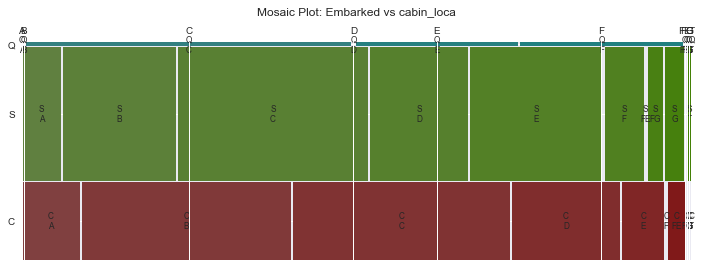

In [68]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ttl = ax.title
ttl.set_position([.5, 1.1]) # distance between title and plot
mosaic(df.sort_values('cabin_loca'),['Embarked','cabin_loca'],
       ax=ax,gap=0.005,horizontal =False,
       title='Mosaic Plot: Embarked vs cabin_loca',axes_label=True)
pass
print("This plot suggests that cabin location information cannot be directly infered from port of embarkation.")

In [69]:
df.groupby(['Embarked','cabin_loca']).size()

Embarked  cabin_loca
C         A              7
          B             25
          C             26
          D             13
          E              5
          FE             2
Q         C              2
          E              1
          F              1
S         A              8
          B             23
          C             39
          D             20
          E             27
          F              8
          FG             3
          G              4
          T              1
dtype: int64

Here, I add an extra category for the cabin location variable indicating missingness.

In [70]:
df.cabin_loca = df.cabin_loca.fillna(value = "missing")

Rules for missing data imputation:

- For people sharing the same ticket number, I assume their same cabin locations are the same.

- Creat an extra category "missing" for the cabin location variable indicating missingness.

#### Age: age in years

reference:

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

https://pypi.org/project/fancyimpute/

https://github.com/iskandr/fancyimpute/issues/53

I assume the age data is missing at random (MAR), and  impute them using MICE (Multiple Imputation by Chained Equations). 

In [71]:
# MICE doesn't support categorical data
# One-hot encoding is applied here to convert categories into binary indicators
df_x = df.copy()
df_x.drop(['Survived','Ticket'],axis=1,inplace=True)
df_dummies= pd.get_dummies(df_x,drop_first=True)
Xmice = MICE(model = BayesianRidgeRegression(lambda_reg=0.0001),verbose=False).complete(df_dummies.as_matrix())
Xmice = pd.DataFrame(Xmice)
Xmice.columns = df_dummies.columns
Xmice.Age[Xmice.Age<0]=0

(0, 0.07)

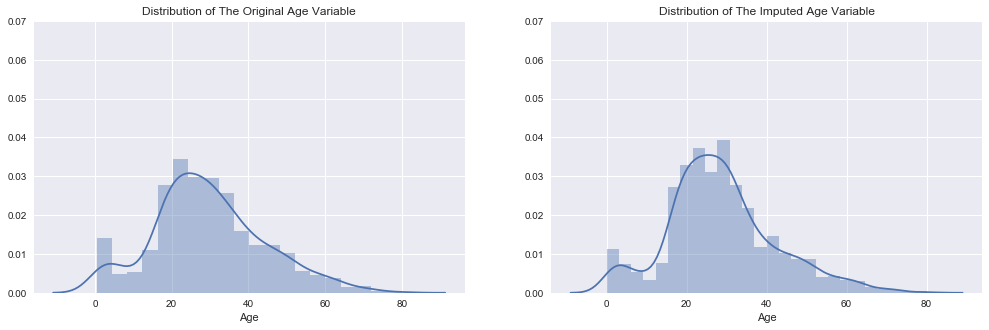

In [72]:
sns.set(rc={'figure.figsize':(17,5)})
plt.subplot(121)
sns.distplot(df.Age.dropna()).set_title('Distribution of The Original Age Variable')
plt.ylim([0,0.07])
plt.subplot(122)
sns.distplot(Xmice.Age).set_title('Distribution of The Imputed Age Variable')
plt.ylim([0,0.07])

## Exploratory Data Analysis